In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import flirt
import neurokit2 as nk

%matplotlib widget

Load wesad data specimen.

In [187]:
wesad_data = '/home/art/Downloads/WESAD/S7/S7.pkl'
dataset = pd.read_pickle(wesad_data)
BVP = dataset['signal']['wrist']['BVP'][:,0]
EDA = dataset['signal']['wrist']['EDA'][:,0]
TEMP = dataset['signal']['wrist']['TEMP'][:,0]
RESP = dataset['signal']['chest']['Resp'][:,0]
ECG = dataset['signal']['chest']['ECG'][:,0]
label = dataset['label']

Upsample wrist data.

In [188]:
ECG_down = nk.signal_resample(ECG, sampling_rate=700, desired_sampling_rate=256, method='interpolation')
RESP_down = nk.signal_resample(RESP, sampling_rate=700, desired_length=len(ECG_down), method='interpolation')
BVP_up = nk.signal_resample(BVP, desired_length=len(ECG_down), method='FFT')
EDA_up = nk.signal_resample(EDA, desired_length=len(ECG_down), method='poly')
TEMP_up = nk.signal_resample(TEMP, desired_length=len(ECG_down), method='poly')
label_resampled = nk.signal_resample(label, desired_length=len(ECG_down), method='interpolation')

data_df = pd.DataFrame(
    {
    'BVP': BVP_up,
    'EDA': EDA_up,
    'TEMP': TEMP_up,
    'ECG': ECG_down,
    'RESP': RESP_down,
    'label' : label_resampled,
}
)

data_df.head()

,BVP,EDA,TEMP,ECG,RESP,label
0,9.570000,5.973745,33.272443,-0.019226,1.832581,0
1,13.690549,6.038064,33.622649,-0.012980,1.837982,0
2,13.802470,6.099970,33.959122,-0.031913,1.795855,0
3,11.086804,6.159436,34.281717,-0.110225,1.797355,0
4,7.410000,6.216439,34.590313,-0.095998,1.817480,0


Get Features out of WESAD Data.

The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
The raw signal, sampled at 256 Hz, was preprocessed using a bandpass filter ([0.5 - 8 Hz], Butterworth 3rd order; following Elgendi et al., 2013).

The peak detection was carried out using the method described in Elgendi et al. (2013).

The quality assessment was carried out using template-matching, approximately as described in Orphanidou et al. (2015).

   PPG_Rate_Mean  PPG_Rate_SD
0      66.285141    24.456355

References
- Elgendi M, Norton I, Brearley M, Abbott D, Schuurmans D (2013)
            Systolic Peak Detection in Acceleration Photoplethysmograms
            Measured from Emergency Responders in Tropical Conditions
            PLo

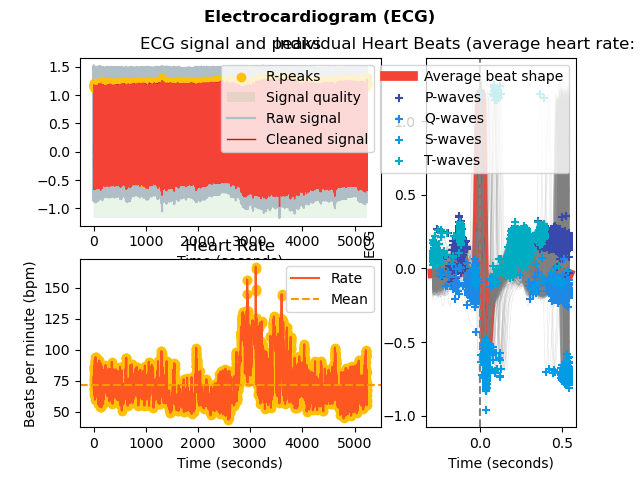

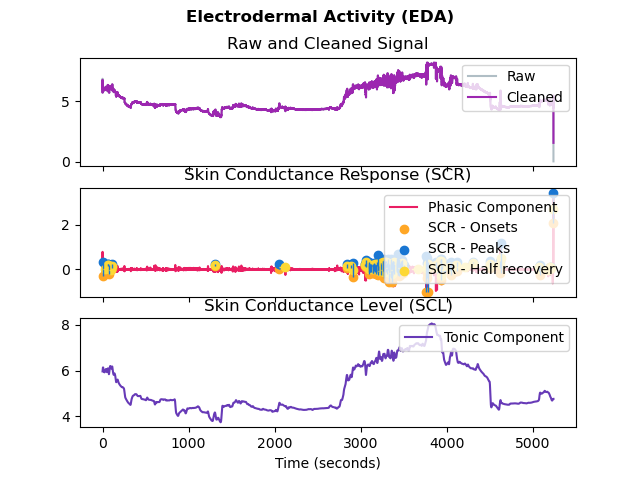

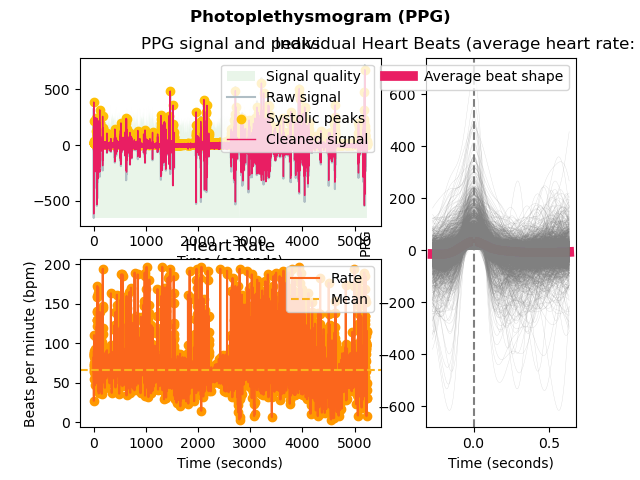

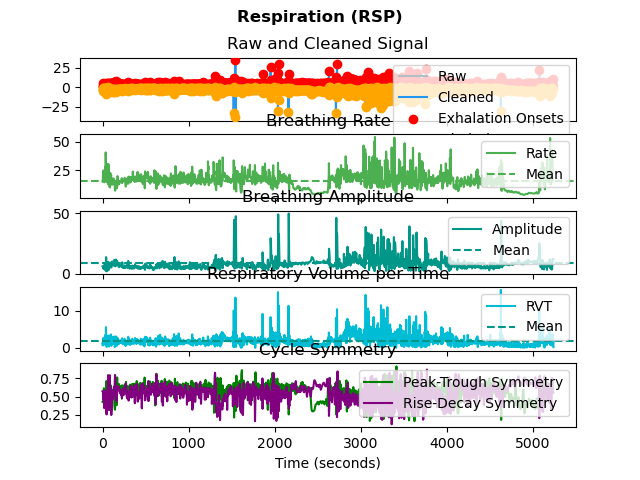

In [189]:
ecg_signals, ecg_info = nk.ecg_process(data_df['ECG'], sampling_rate=256)
nk.ecg_plot(ecg_signals, ecg_info)
eda_signals, eda_info = nk.eda_process(data_df['EDA'], sampling_rate=256, report='Text')
nk.eda_plot(eda_signals, eda_info)
ppg_signals, ppg_info = nk.ppg_process(data_df['BVP'], sampling_rate=256, report='Text')
nk.ppg_plot(ppg_signals, ppg_info)
resp_signals, resp_info = nk.rsp_process(data_df['RESP'], sampling_rate=256, method='khodadad2018', method_rvt='harrison2021', report='Text')
nk.rsp_plot(resp_signals, resp_info)


In [190]:
quick_feat = flirt.with_.empatica('/home/art/Downloads/WESAD/S7/S7_E4_Data.zip',
                                  window_length= 60,
                                  window_step_size = 1,
                                  hrv_features = True,
                                  eda_features = True,
                                  acc_features = True)

HRV features: 100%|██████████| 6403/6403 [00:05<00:00, 1116.35it/s]


EDA features:   0%|          | 0/6494 [00:00<?, ?it/s]

/tmp/ipykernel_335021/1998099736.py:1: UserWarning: phasic_entropy contains more than 5% (actual: 63.3%) nan, inf, or -inf values. We recommend to delete this feature column.
  quick_feat = flirt.with_.empatica('/home/art/Downloads/WESAD/S7/S7_E4_Data.zip',


ACC features:   0%|          | 0/6495 [00:00<?, ?it/s]

/home/art/miniconda3/envs/biosig/lib/python3.12/site-packages/flirt/stats/common.py:35: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[key] = value(data)
/home/art/miniconda3/envs/biosig/lib/python3.12/site-packages/flirt/stats/common.py:35: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[key] = value(data)


In [192]:
from skchange.change_detectors import MovingWindow
from skchange.change_scores import CUSUM

detector = MovingWindow(
    change_score=CUSUM(),  # measures the difference in mean between two intervals.
    bandwidth=20,
    threshold_scale=1.0,
)
display(detector)

MovingWindow(bandwidth=20, change_score=CUSUM(), threshold_scale=1.0)

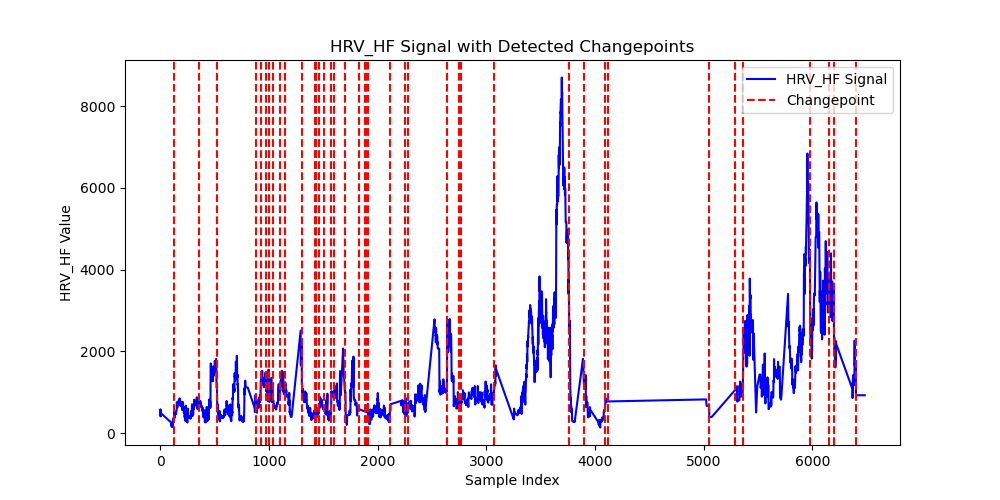

In [193]:
hrv_hf = quick_feat['hrv_hf'].dropna().reset_index(drop=True)
hrv_hf_detections = detector.fit_predict(hrv_hf)
hrv_changepoints = hrv_hf_detections.get("ilocs", [])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hrv_hf.index, hrv_hf.values, label="HRV_HF Signal", color="blue")

for i, hrv_changepoint in enumerate(hrv_changepoints):
    ax.axvline(x=hrv_changepoint, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

ax.set_title("HRV_HF Signal with Detected Changepoints")
ax.set_xlabel("Sample Index")
ax.set_ylabel("HRV_HF Value")
ax.legend()
plt.show()

MovingWindow(bandwidth=180, change_score=CUSUM(), threshold_scale=1.0)

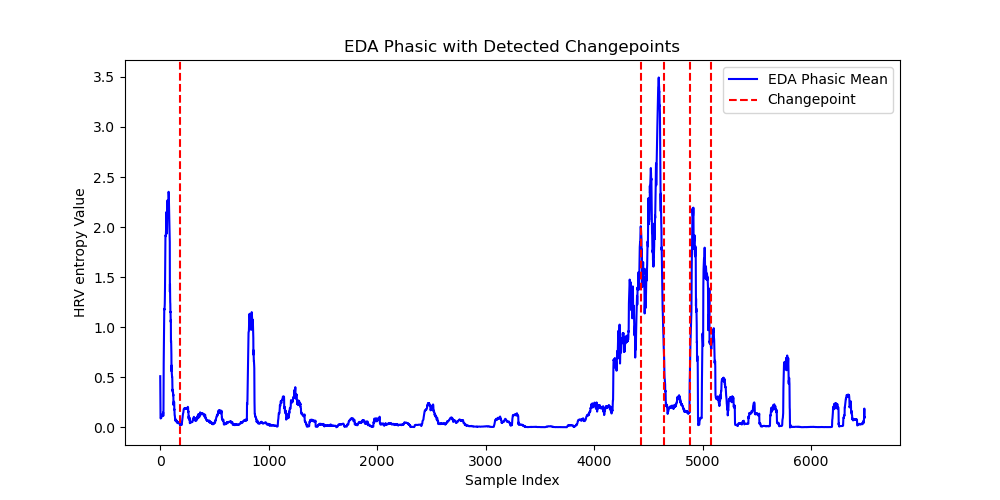

In [194]:
detector = MovingWindow(change_score=CUSUM(), bandwidth=180, threshold_scale=1.0)
display(detector)
eda_phasic_mean = quick_feat['eda_phasic_mean'].dropna().reset_index(drop=True)
eda_phasic_detect = detector.fit_predict(eda_phasic_mean)
eda_phasic_changepoints = eda_phasic_detect.get("ilocs", [])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eda_phasic_mean.index, eda_phasic_mean.values, label="EDA Phasic Mean", color="blue")

for i, eda_phasic_changepoints in enumerate(eda_phasic_changepoints):
    ax.axvline(x=eda_phasic_changepoints, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

ax.set_title("EDA Phasic with Detected Changepoints")
ax.set_xlabel("Sample Index")
ax.set_ylabel("HRV entropy Value")
ax.legend()
plt.show()

MovingWindow(bandwidth=180, change_score=CUSUM(), threshold_scale=1)

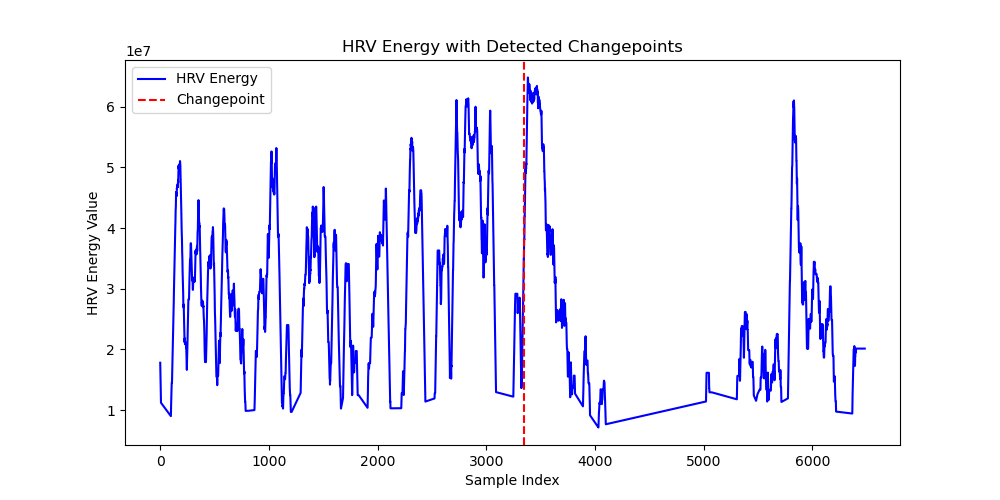

In [195]:
detector = MovingWindow(change_score=CUSUM(), bandwidth=180, threshold_scale=1)
display(detector)
hrv_energy = quick_feat['hrv_energy'].dropna().reset_index(drop=True)
hrv_energy_detect = detector.fit_predict(hrv_energy)
hrv_energy_changepoints = hrv_energy_detect.get("ilocs", [])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hrv_energy.index, hrv_energy.values, label="HRV Energy", color="blue")

for i, hrv_energy_changepoints in enumerate(hrv_energy_changepoints):
    ax.axvline(x=hrv_energy_changepoints, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

ax.set_title("HRV Energy with Detected Changepoints")
ax.set_xlabel("Sample Index")
ax.set_ylabel("HRV Energy Value")
ax.legend()
plt.show()

MovingWindow(bandwidth=1000, change_score=CUSUM(), threshold_scale=1.0)

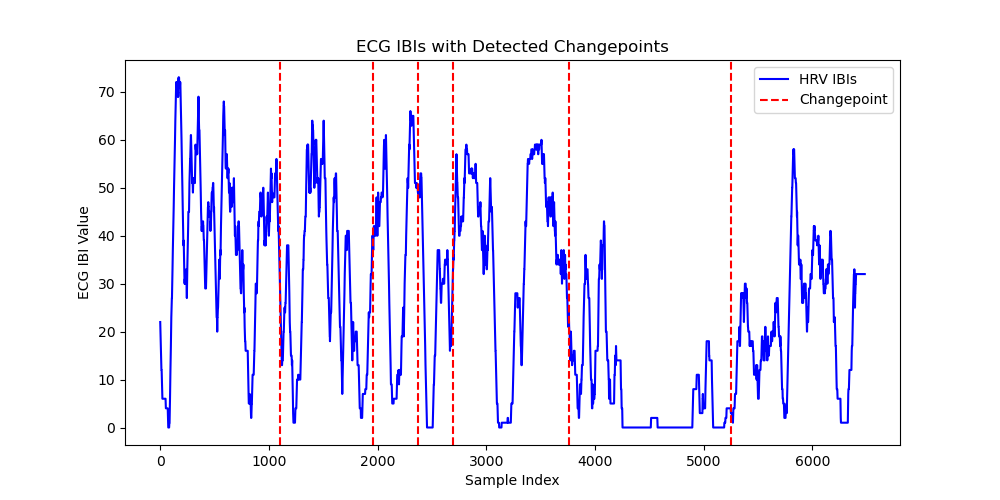

In [196]:
detector = MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0)
display(detector)
ECG_IBIs = quick_feat['num_ibis'].dropna().reset_index(drop=True)
ecg_ibi_detect = detector.fit_predict(ECG_IBIs)
ecg_ibi_changepoints = ecg_ibi_detect.get("ilocs", [])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ECG_IBIs.index, ECG_IBIs.values, label="HRV IBIs", color="blue")

for i, ecg_ibi_changepoints in enumerate(ecg_ibi_changepoints):
    ax.axvline(x=ecg_ibi_changepoints, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

ax.set_title("ECG IBIs with Detected Changepoints")
ax.set_xlabel("Sample Index")
ax.set_ylabel("ECG IBI Value")
ax.legend()
plt.show()

MovingWindow(bandwidth=1000, change_score=CUSUM(), threshold_scale=1.0)

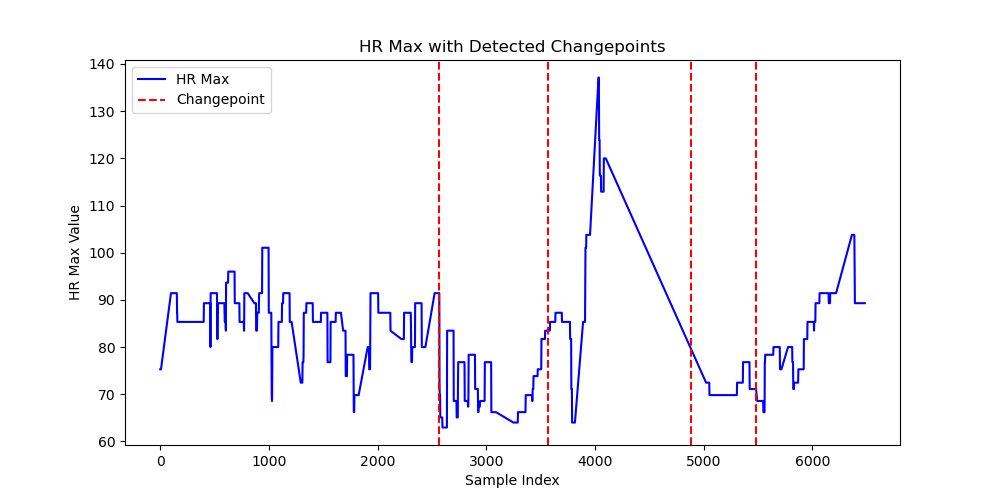

In [197]:
detector = MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0)
display(detector)
hr_max = quick_feat['hrv_max_hr'].dropna().reset_index(drop=True)
hr_max_detect = detector.fit_predict(hr_max)
hr_max_changepoints = hr_max_detect.get("ilocs", [])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hr_max.index, hr_max.values, label="HR Max", color="blue")

for i, hr_max_changepoints in enumerate(hr_max_changepoints):
    ax.axvline(x=hr_max_changepoints, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

ax.set_title("HR Max with Detected Changepoints")
ax.set_xlabel("Sample Index")
ax.set_ylabel("HR Max Value")
ax.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 22), sharex=True)
fig.suptitle("Subject 7")
signals = [
    ("hrv_max_hr", "HR Max"),
    ("num_ibis", "ECG IBIs"),
    ("hrv_energy", "HRV Energy"),
    ("eda_phasic_mean", "EDA Phasic Mean"),
    ("hrv_hf", "HRV_HF Signal"),
    ("hrv_rmssd", "HRV RMMSD"),
    ("hrv_lf_hf_ratio", "HRV LF/HF Ratio")
]
# Hyperparamaters.... 
detectors = [
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=1.0)
]

for ax, (signal_name, title), detector in zip(axes, signals, detectors):
    signal_data = quick_feat[signal_name].dropna().reset_index(drop=True)
    detection_results = detector.fit_predict(signal_data)
    changepoints = detection_results.get("ilocs", [])

    ax.plot(signal_data.index, signal_data.values, label=title, color="blue")
    
    for i, changepoint in enumerate(changepoints):
        ax.axvline(x=changepoint, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

    ax.set_title(f"{title} with Detected Changepoints")
    ax.set_ylabel(f"{title} Value")
    ax.legend()

axes[-1].set_xlabel("Sample Index")

plt.show()

Subject 4

In [199]:
quick_feat4 = flirt.with_.empatica('/home/art/Downloads/WESAD/S4/S4_E4_Data.zip',
                                  window_length= 60,
                                  window_step_size = 1,
                                  hrv_features = True,
                                  eda_features = True,
                                  acc_features = True,
                                  debug = True
                                  )

Reading files
Calculating HRV features


HRV features: 100%|██████████| 7771/7771 [00:00<00:00, 12245.69it/s]


Calculating EDA features


EDA features:   0%|          | 0/8000 [00:00<?, ?it/s]

Calculating ACC features


/tmp/ipykernel_335021/419229283.py:1: UserWarning: phasic_entropy contains more than 5% (actual: 73.44%) nan, inf, or -inf values. We recommend to delete this feature column.
  quick_feat4 = flirt.with_.empatica('/home/art/Downloads/WESAD/S4/S4_E4_Data.zip',


ACC features:   0%|          | 0/8000 [00:00<?, ?it/s]

/home/art/miniconda3/envs/biosig/lib/python3.12/site-packages/flirt/stats/common.py:35: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[key] = value(data)


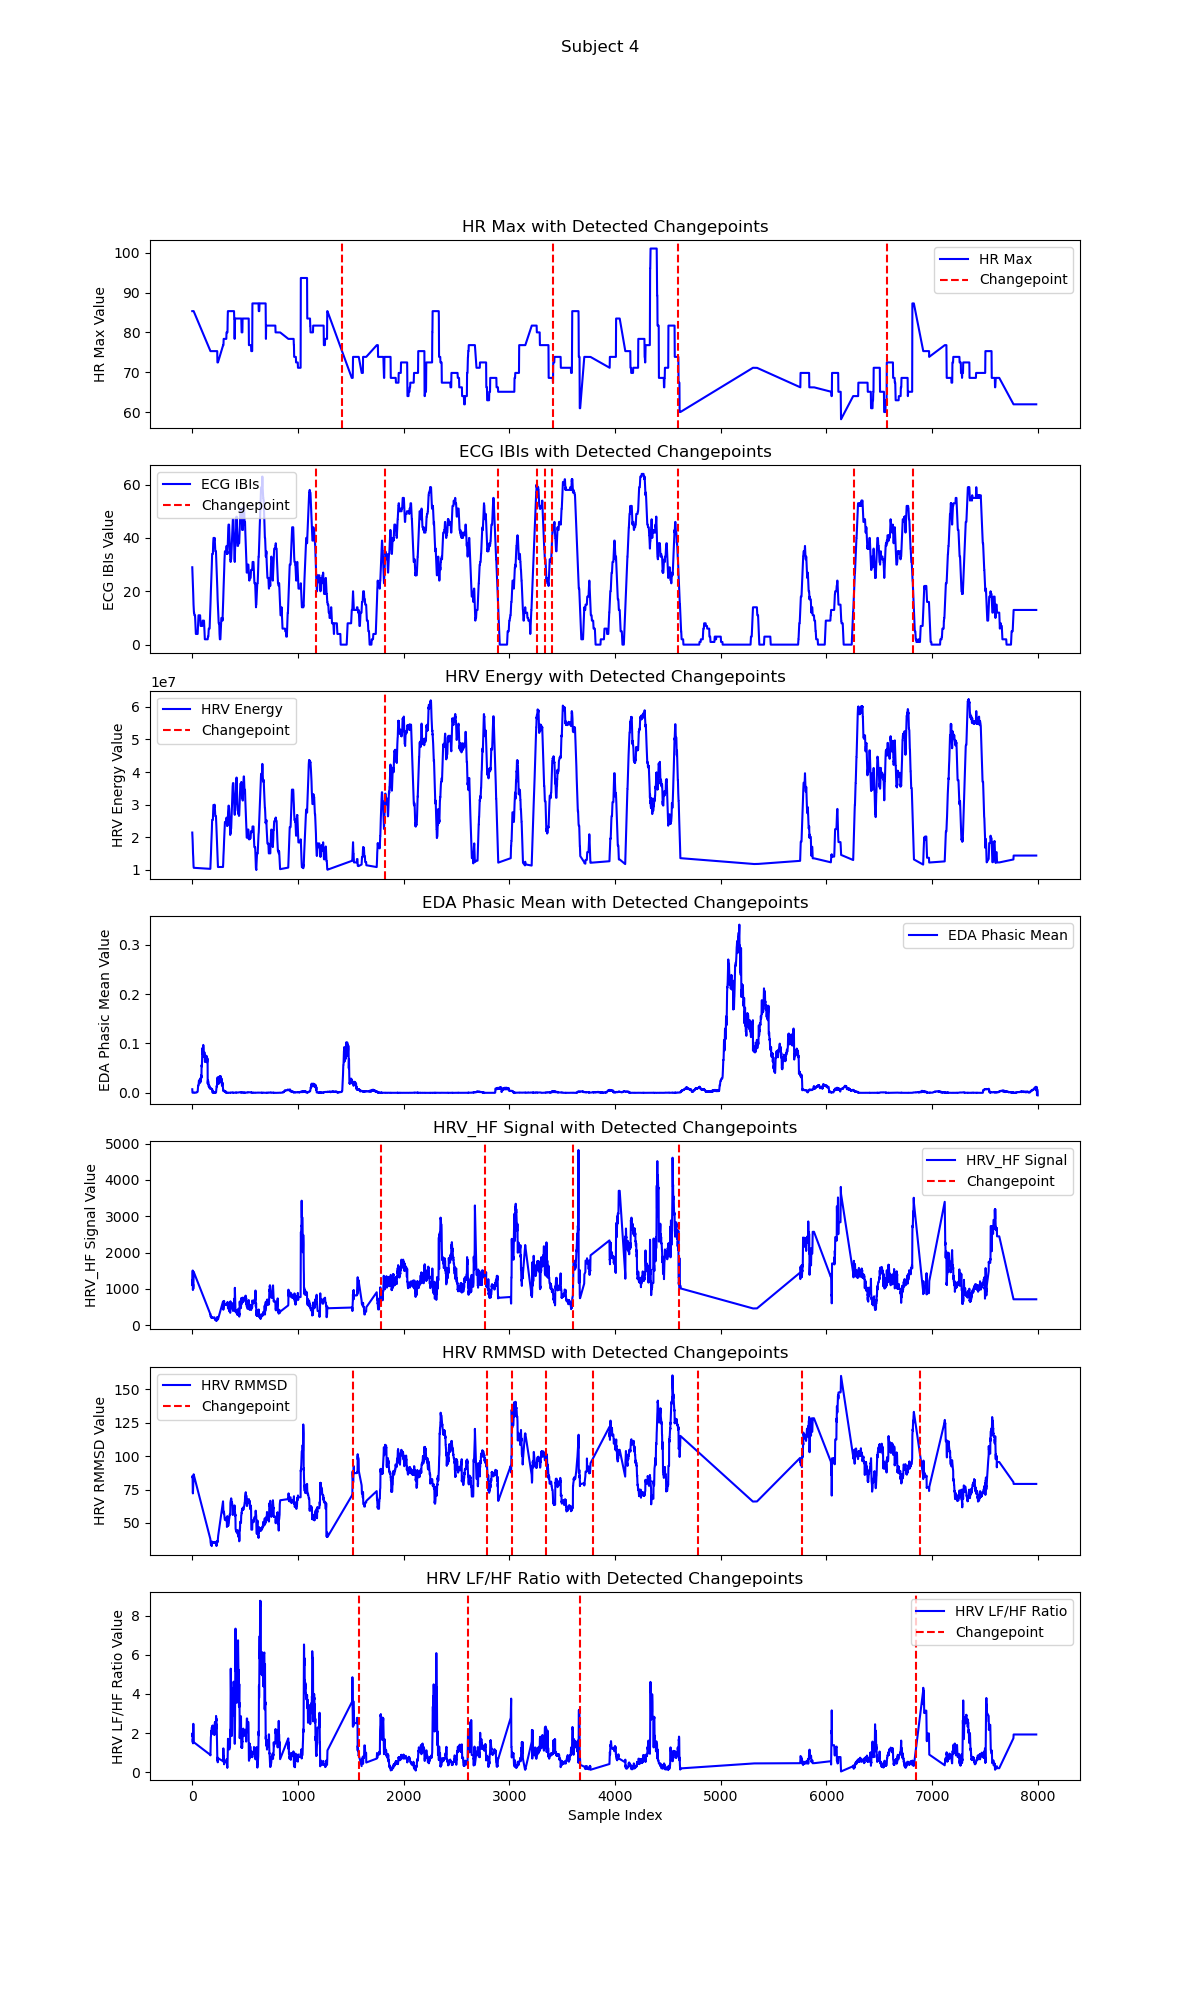

In [200]:

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 20), sharex=True)
fig.suptitle('Subject 4')
signals = [
    ("hrv_max_hr", "HR Max"),
    ("num_ibis", "ECG IBIs"),
    ("hrv_energy", "HRV Energy"),
    ("eda_phasic_mean", "EDA Phasic Mean"),
    ("hrv_hf", "HRV_HF Signal"),
    ("hrv_rmssd", "HRV RMMSD"),
    ("hrv_lf_hf_ratio", "HRV LF/HF Ratio")
]
# Hyperparamaters.... 
detectors = [
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1000, threshold_scale=.5)
]

for ax, (signal_name, title), detector in zip(axes, signals, detectors):
    signal_data = quick_feat4[signal_name].dropna().reset_index(drop=True)
    detection_results = detector.fit_predict(signal_data)
    changepoints = detection_results.get("ilocs", [])

    ax.plot(signal_data.index, signal_data.values, label=title, color="blue")
    
    for i, changepoint in enumerate(changepoints):
        ax.axvline(x=changepoint, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

    ax.set_title(f"{title} with Detected Changepoints")
    ax.set_ylabel(f"{title} Value")
    ax.legend()

axes[-1].set_xlabel("Sample Index")
plt.show()

Subject 6

In [201]:
quick_feat6 = flirt.with_.empatica('/home/art/Downloads/WESAD/S6/S6_E4_Data.zip',
                                  window_length= 60,
                                  window_step_size = 1,
                                  hrv_features = True,
                                  eda_features = True,
                                  acc_features = True,
                                  debug = True
                                  )

Reading files
Calculating HRV features


HRV features: 100%|██████████| 8085/8085 [00:00<00:00, 40700.97it/s]


Calculating EDA features


EDA features:   0%|          | 0/8324 [00:00<?, ?it/s]

Calculating ACC features


/tmp/ipykernel_335021/1399992444.py:1: UserWarning: phasic_entropy contains more than 5% (actual: 63.27%) nan, inf, or -inf values. We recommend to delete this feature column.
  quick_feat6 = flirt.with_.empatica('/home/art/Downloads/WESAD/S6/S6_E4_Data.zip',


ACC features:   0%|          | 0/8324 [00:00<?, ?it/s]

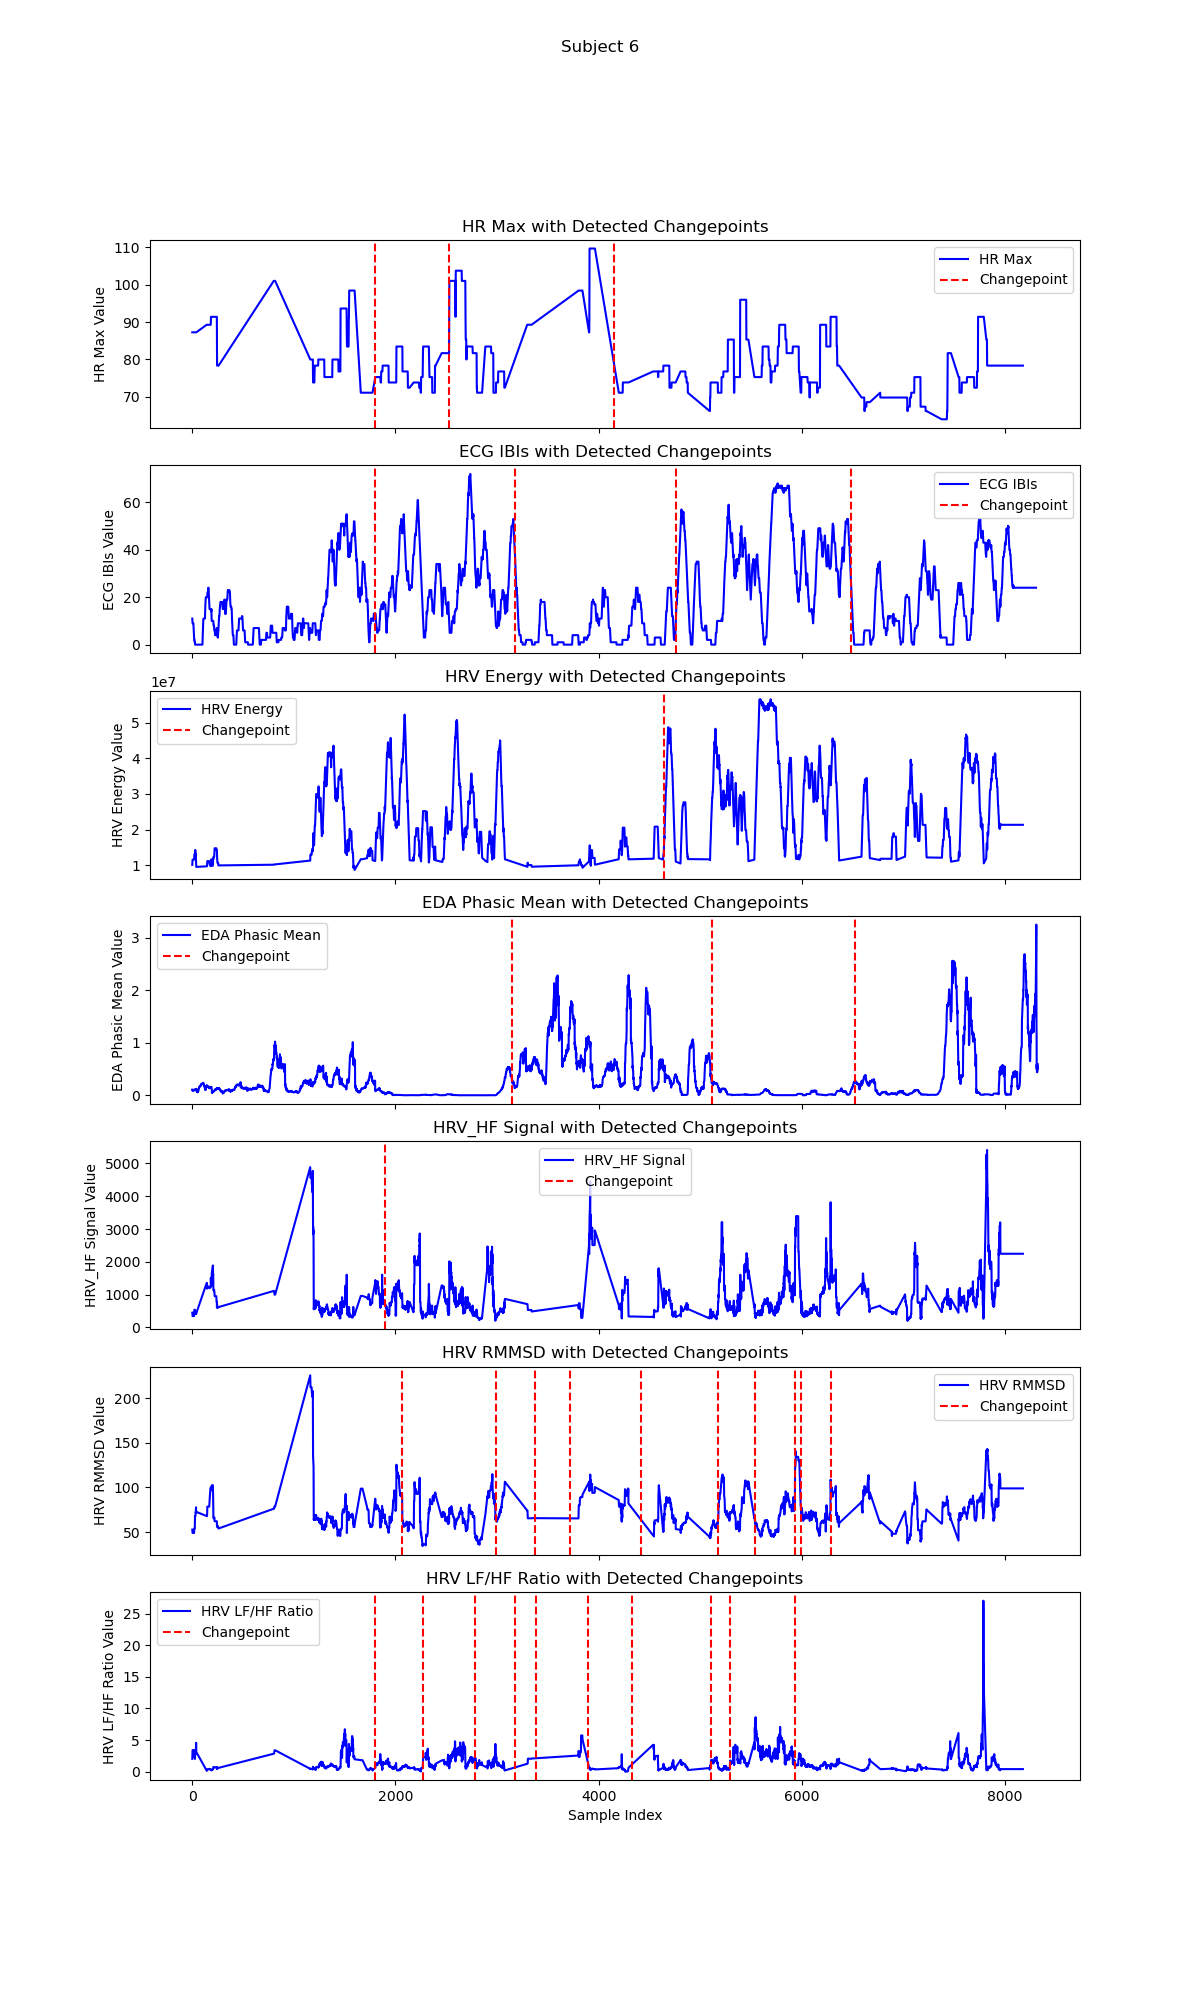

In [202]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 20), sharex=True)
fig.suptitle('Subject 6')
signals = [
    ("hrv_max_hr", "HR Max"),
    ("num_ibis", "ECG IBIs"),
    ("hrv_energy", "HRV Energy"),
    ("eda_phasic_mean", "EDA Phasic Mean"),
    ("hrv_hf", "HRV_HF Signal"),
    ("hrv_rmssd", "HRV RMMSD"),
    ("hrv_lf_hf_ratio", "HRV LF/HF Ratio")
]
# Hyperparamaters.... 
detectors = [
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5),
    MovingWindow(change_score=CUSUM(), bandwidth=1800, threshold_scale=.5)
]

for ax, (signal_name, title), detector in zip(axes, signals, detectors):
    signal_data = quick_feat6[signal_name].dropna().reset_index(drop=True)
    detection_results = detector.fit_predict(signal_data)
    changepoints = detection_results.get("ilocs", [])

    ax.plot(signal_data.index, signal_data.values, label=title, color="blue")
    
    for i, changepoint in enumerate(changepoints):
        ax.axvline(x=changepoint, linestyle="dashed", color="red", label="Changepoint" if i == 0 else "")

    ax.set_title(f"{title} with Detected Changepoints")
    ax.set_ylabel(f"{title} Value")
    ax.legend()

axes[-1].set_xlabel("Sample Index")
plt.show()